In [1]:
import numpy as np
import time
import gc
import matplotlib.pyplot as plt
import os
from PIL import Image 
from astropy.visualization import astropy_mpl_style
from astropy.io import fits
plt.style.use(astropy_mpl_style)

from otsu import otsu
from cross_corr import cross_corr

kadr_num = 0 # номер кадра для отображения на графиках 
D = 2.5 # диаметр телескопа, [м]
latency = 4 # временная задержка в кросс-корреляции, [кол-во кадров] 
file_bias = "bias20210130.fits"
file = "20210130l_m2km.fits" # "20210130l_m2km.fits"

Filename: bias20210130.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (329, 246, 1000)   int16 (rescales to uint16)   
Filename: 20210130l_m2km.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (329, 246, 6000)   int16 (rescales to uint16)   
 
time:  2.797823905944824


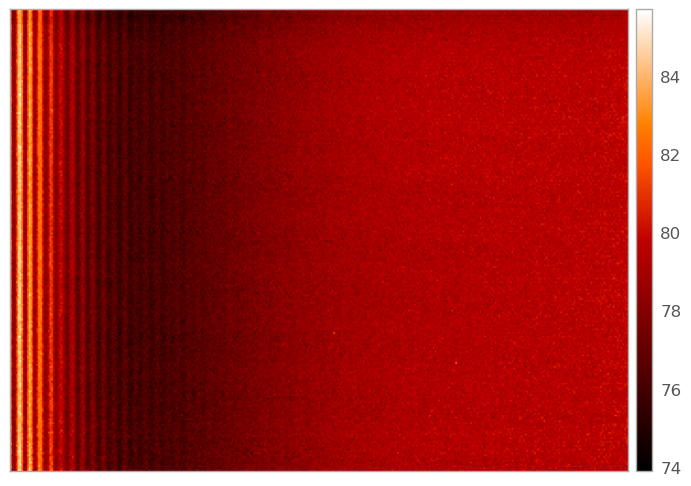

In [2]:
st = time.time()

with fits.open(os.listdir(os.getcwd())[os.listdir(os.getcwd()).index(file_bias)]) as event_filename1:
    event_filename1.info()
    image_data_bias = event_filename1[0].data
    header1 = event_filename1[0].header

with fits.open(os.listdir(os.getcwd())[os.listdir(os.getcwd()).index(file)]) as event_filename2: 
    event_filename2.info()
    image_data = event_filename2[0].data

frames_per_sec = 1 / header1['FRATE'] # временные промежутки между кадрами, [сек]
avr_bias = np.mean(image_data_bias, axis=0, dtype='float32') # средний кадр смещения
new_image_data = np.float32(image_data - avr_bias) # попиксельное вычитание среднего кадра смещения из кадров серии 

fig = plt.figure()
ax = plt.axes()
im = plt.imshow(avr_bias)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)
ax.grid(False)
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

del image_data_bias, image_data, header1, avr_bias
gc.collect()

print(' ')
print('time: ', time.time() - st)

C:\Users\miron\coding\Domecam\otsu.py:23: RuntimeWarning: invalid value encountered in true_divide
  muf = np.sum(intensity_arr[t:]*his[t:]) / float(pcf)


time:  6.16950249671936


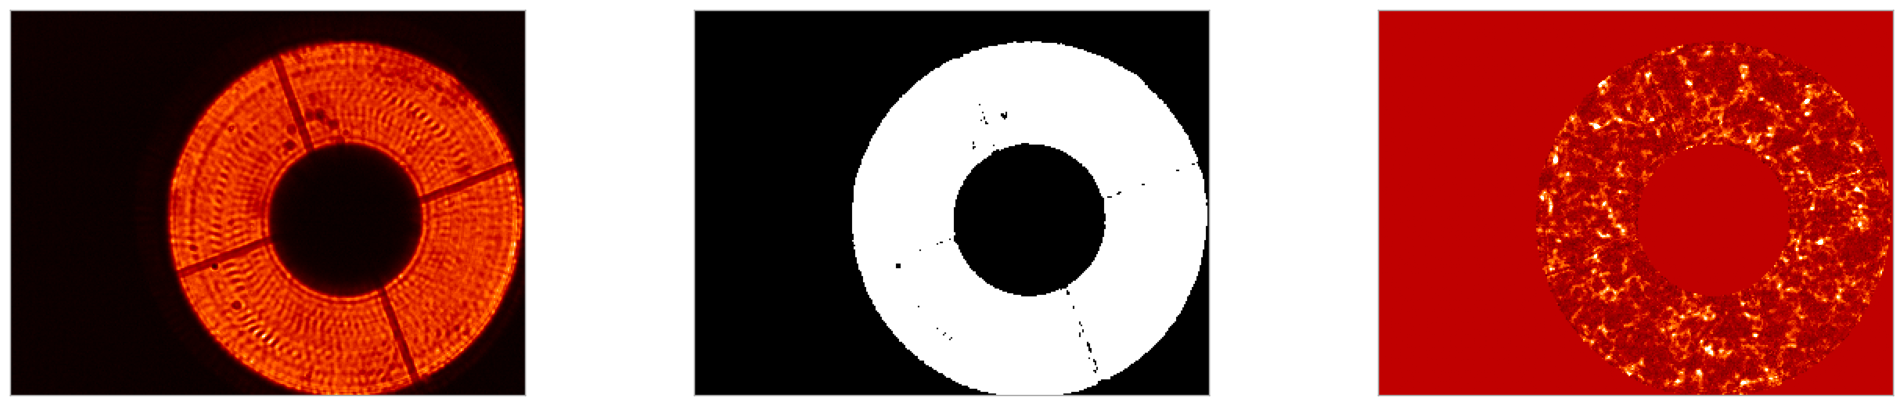

In [3]:
st = time.time()

avr = np.mean(new_image_data, axis=0, dtype='float32') # средний кадр из серии 

fig, (ax_img1, ax_img2, ax_img3) = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
ax_img1.imshow(avr)
ax_img1.grid(False)
ax_img1.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

norm = np.float32((new_image_data)/(avr) - 1) # нормировка 
maxval = int(255)
im_bin = np.float32((avr > otsu(avr)) * maxval) #маска Оцу 
new_norm = np.float32(norm * im_bin) # результат маски Оцу, наложенной на нормированные изображения

ax_img2.imshow(im_bin, cmap='gray')
ax_img2.grid(False)
ax_img2.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

ax_img3.imshow(new_norm[kadr_num], vmin=-1000, vmax = 1000)
ax_img3.grid(False)
ax_img3.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

del im_bin, avr, norm, new_image_data
gc.collect()

print('time: ', time.time() - st)

size: 226 x 227
1 of 6000 frames
 
time:  0.055622100830078125


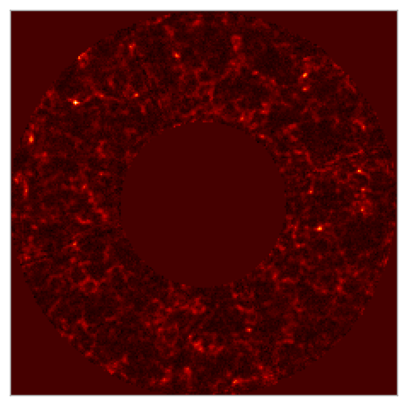

In [4]:
st = time.time()

mask = new_norm[0] != 0
rows = np.flatnonzero((mask.any(axis=1))) 
cols = np.flatnonzero((mask.any(axis=0)))
squared = new_norm[:, rows.min():rows.max()+1, cols.min():cols.max()+1]    

fig = plt.figure(figsize=(25,5))
ax = plt.axes()
im = plt.imshow(squared[kadr_num])
ax.grid(False)
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

print('size:', squared.shape[1], 'x', squared.shape[2])
print('1 of', squared.shape[0], 'frames')

del mask, rows, cols
gc.collect()

print(' ')
print('time: ', time.time() - st)

test.shape[2] 227
avr_cross.shape[0] 226
size: (226, 227)
corr: 1 of 6000 frames
1 pixel equals to 0.011013215859030838 meters
 
time:  91.07134747505188


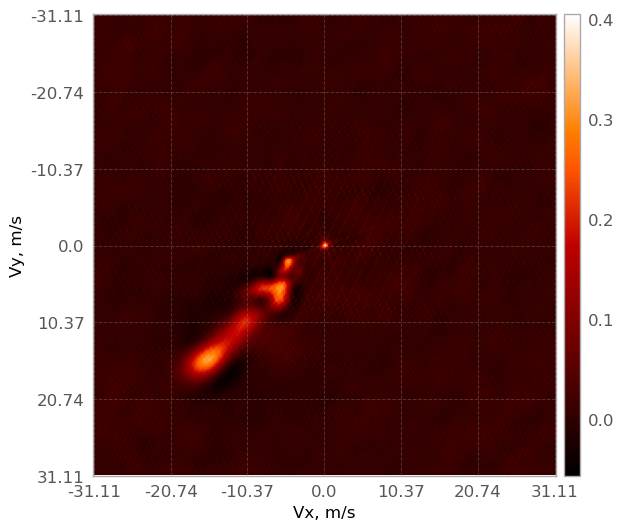

In [5]:
st = time.time()
all_corr = np.zeros((squared.shape))
for i in range(0, squared.shape[0]-latency, 1):
    all_corr[i] = cross_corr(squared[i], squared[i+latency])
    
avr_cross = np.mean(all_corr, axis=0, dtype='float32')

t = latency * frames_per_sec
k = D / squared.shape[2] # соотношение между расстоянием в метрах и 1 пикселем
L = avr_cross.shape[0]
v = k / t

fig = plt.figure()
ax = plt.axes()
im = plt.imshow(avr_cross)
ax.set_xticks(np.linspace(0, L, 7), np.round(v*np.linspace(-L//2, L//2, 7), 2), fontsize=12)
ax.set_yticks(np.linspace(0, L, 7), np.round(v*np.linspace(-L//2, L//2, 7), 2), fontsize=12)
ax.set_ylabel('Vy, m/s', fontsize=12)
ax.set_xlabel('Vx, m/s', fontsize=12)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)
ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
plt.savefig(f'C:/astro/corr_with_latency_{latency}.png', bbox_inches='tight')

print('test.shape[2]', squared.shape[2])
print('avr_cross.shape[0]', avr_cross.shape[0])

print('size:', avr_cross.shape)
print('corr: 1 of', len(all_corr), 'frames')
print('1 pixel equals to', k, 'meters')

del all_corr, avr_cross
gc.collect()

print(' ')
print('time: ', time.time() - st)

In [6]:
# st = time.time()

# img = Image.fromarray(np.float32(squared[0]))
# rotate_img = img.rotate(-20)
# #rotate_img.show()
# I = np.asarray(rotate_img) 
# plt.figure()
# plt.imshow(I)
# plt.colorbar()
# plt.grid(False)
# #рассчет градуса отклонения (?)

# print(' ')
# print('time: ', time.time() - st)

In [7]:
del squared
gc.collect()

0